In [1]:
using Flux
using Flux: @epochs, throttle
using ExprOptimization
using Base.Iterators: repeated
using BSON
using Plots
using LinearAlgebra
using JLD2, FileIO


# Function to plot loss

In [2]:
function plotLoss(lossVals)
    floatLossVals = [Tracker.data(lv) for lv in lossVals]
    gr(fmt=:png)
    plot()
    plot!(floatLossVals,
        xlabel = "time",
        ylabel = "loss",
        label = "mse loss",
        title = "loss evolution")
end

plotLoss (generic function with 1 method)

In [77]:
function plotLossOnSameFigure!(lossVals, lbl = "mse loss", colorNum = nothing)
    floatLossVals = [Tracker.data(lv) for lv in lossVals]
    if colorNum != nothing
        p = plot!(floatLossVals,
        xlabel = "epochs",
        ylabel = "loss",
        label = lbl,
        title = "loss evolution",
        color = colorNum)
    else
        p = plot!(floatLossVals,
            xlabel = "epochs",
            ylabel = "loss",
            label = lbl,
            title = "loss evolution")
    end
    return p
end

plotLossOnSameFigure! (generic function with 3 methods)

# Example of how to use Flux

In [25]:
function train_model(model, X_train, Y_train; verbose = false)
    loss(x, y) = Flux.mse(model(x), y)
    data = repeated((X_train, Y_train), 10)
    opt = Flux.Optimise.ADAM()
    lossVals = [loss(X_train,Y_train)]
    evalcb = () -> begin curLoss = loss(X_train,Y_train)
        push!(lossVals, curLoss)
        verbose && @show(curLoss) end
    evalcb2 = () -> BSON.@save "model-flux-trial.bson" model
    verbose && @show loss(X_train,Y_train)
    @epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30), throttle(evalcb2, 60)])
    verbose && @show lossVals
    verbose && plotLoss(lossVals)
    return lossVals
end

train_model (generic function with 1 method)

In [26]:
input_size = 3
output_size = 1
X_train = [zeros(input_size,10) ones(input_size,10) 2*ones(input_size,10) 3*ones(input_size,10) zeros(input_size,10)]
Y_train = [zeros(output_size,10) ones(output_size,10) ones(output_size,10) ones(output_size,10) zeros(output_size,10)]
model = Chain(Dense(input_size,128, relu), Dense(128,output_size, relu)) 


Chain(Dense(3, 128, NNlib.relu), Dense(128, 1, NNlib.relu))

In [24]:
train_model(model, X_train, Y_train)

┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


11-element Array{Tracker.TrackedReal{Float64},1}:
 0.1010516373091754 
 0.08940615105724167
 0.08370742327295927
 0.08293620163619472
 0.08452701673931094
 0.08556390417860624
 0.08490720399302261
 0.0829203202384882 
 0.08042257133895689
 0.07805512617701264
 0.07630893619236821

In [27]:
train_model(model, X_train, Y_train, verbose = true)

loss(X_train, Y_train) = 0.6 (tracked)
curLoss = 0.6 (tracked)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)


┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)


┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


lossVals = Tracker.TrackedReal{Float64}[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]


11-element Array{Tracker.TrackedReal{Float64},1}:
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6

In [91]:
@show model(ones(input_size,1))
@show model(3*ones(input_size,1))
@show model(5*ones(input_size,1))
@show model(zeros(input_size,1))

model(ones(input_size, 1)) = Float32[1.00201] (tracked)
model(3 * ones(input_size, 1)) = Float32[0.996905] (tracked)
model(5 * ones(input_size, 1)) = Float32[0.986082] (tracked)
model(zeros(input_size, 1)) = Float32[0.0] (tracked)


Tracked 1×1 Array{Float32,2}:
 0.0f0

# Example of ExprOptimization

In [177]:
const grammar = @grammar begin
    Real = x
    Real = Real * Real
    Real = Real + Real
    Real = Real - Real
    Real = |(1:5)
end

1: Real = x
2: Real = Real * Real
3: Real = Real + Real
4: Real = Real - Real
5: Real = 1
6: Real = 2
7: Real = 3
8: Real = 4
9: Real = 5


In [178]:
const S = SymbolTable(grammar)


Dict{Symbol,Any} with 5 entries:
  :+    => +
  :Real => Real
  :-    => -
  :*    => *
  :x    => [1, 2, 3, 2]

In [179]:
ground_truth(x) = x*x + 2x + 1
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    los = 0.0
    for x = -5.0:1.0:5.0
        S[:x] = x
        los += abs2(Core.eval(S,ex) - ground_truth(x))
    end
    los
end

loss (generic function with 2 methods)

## MonteCarlo Arguments:
- num_samples::Int: number of samples
- max_depth::Int: maximum depth of derivation tree

In [180]:
using Random
Random.seed!(10)
p = MonteCarlo(20000, 6)
results_mc = optimize(p, grammar, :Real, loss)
(results_mc.expr, results_mc.loss)

(:((x + 3) * x), 121.0)

In [182]:
display(results_mc.tree, grammar)


TreeView.LabelledTree({5, 4} directed simple Int64 graph, Any[:*, :+, :x, 3, :x])

## GeneticProgram Arguments
- pop_size::Int: population size
- iterations::Int: number of iterations
- max_depth::Int: maximum depth of derivation tree
- p_reproduction::Float64: probability of reproduction operator
- p_crossover::Float64: probability of crossover operator
- p_mutation::Float64: probability of mutation operator
- init_method::InitializationMethod: initialization method
- select_method::SelectionMethod: selection method

In [184]:
Random.seed!(1)
p = GeneticProgram(1000,20,6,0.3,0.3,0.4)
results_gp = optimize(p, grammar, :Real, loss)
(results_gp.expr, results_gp.loss)

(:((x * 2 + (x * x - 3)) + 4), 0.0)

In [186]:
@show results_gp

results_gp = ExprOptResult(3{3{2{1,6}4{2{1,1}7}}8}, 0.0, :((x * 2 + (x * x - 3)) + 4), nothing)


ExprOptResult(3{3{2{1,6}4{2{1,1}7}}8}, 0.0, :((x * 2 + (x * x - 3)) + 4), nothing)

# Try with the real training data and model

In [50]:
function train_model(model, X_train, Y_train; verbose = false)
    loss(x, y) = Flux.mse(model(x), y)
    data = repeated((X_train, Y_train), 1)
    opt = Flux.Optimise.ADAM()
    lossVals = [loss(X_train,Y_train)]
    evalcb = () -> begin curLoss = loss(X_train,Y_train)
        push!(lossVals, curLoss)
        verbose && @show(curLoss) end
    evalcb2 = () -> BSON.@save "model-flux-trial.bson" model
    verbose && @show loss(X_train,Y_train)
    @epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30), throttle(evalcb2, 60)])
    verbose && @show lossVals
    verbose && plotLoss(lossVals)
    return lossVals
end

train_model (generic function with 1 method)

In [51]:
input_size = 188
output_size = 6
JLD2.@load "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals2.jld2" train_input_collected train_output_collected
@show size(train_input_collected)
@show size(train_output_collected)

X_train = train_input_collected[1:1200,:]
X_test = train_input_collected[1200:end,:]

Y_train = train_output_collected[1:1200, 181:186]
Y_test = train_output_collected[1200:end, 181:186]

@show size(X_train)
@show size(X_test)
@show size(Y_train)
@show size(Y_test)

size(train_input_collected) = (1560, 188)
size(train_output_collected) = (1560, 186)
size(X_train) = (1200, 188)
size(X_test) = (361, 188)
size(Y_train) = (1200, 6)
size(Y_test) = (361, 6)


(361, 6)

In [52]:
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    model = []
    model = Core.eval(S,ex)
    println(model)
    push!(models_tested, model)
    @show model.layers[1]
#     @show size(X_train)
    loss_vals = train_model(model, X_train[1,:], Y_train[1,:], verbose = false)

    Y_NN = model(X_test[1,:])
    # println("input $X_test")
    Y_NN = [Tracker.data(ynn) for ynn in Y_NN]
    println("output $Y_NN")
    println("expected output $(Y_test[1,:])")
#     @show size(Y_NN)
#     @show size(Y_test)
    los = norm(Y_NN - Y_test[1,:])
    println("that worked")
    push!(model_final_losses, los)
    push!(model_all_losses, loss_vals)
#     push!(model_losses, los)
    println("returning $los")
    return los
end

loss (generic function with 1 method)

In [53]:
const grammar = @grammar begin
model = Chain(in_layer1, layer1, layer1, out_layer1) | Chain(in_layer1, layer1, layer1, layer1, out_layer1) | Chain(in_layer2, layer2, layer2, out_layer2) | Chain(in_layer2, layer2, layer2, layer2, out_layer2)
in_layer1 = Dense(input_size, 256, activation)
out_layer1 = Dense(256, output_size, activation)
layer1 = Dense(256,256, activation)
in_layer2 = Dense(input_size, 512, activation)
out_layer2 = Dense(512, output_size, activation)
layer2 = Dense(512,512, activation)
activation = relu
end

const S = SymbolTable(grammar)

Dict{Symbol,Any} with 5 entries:
  :output_size => 6
  :relu        => relu
  :Chain       => Chain
  :Dense       => Dense
  :input_size  => 188

In [88]:
using Random
Random.seed!(9)
p = MonteCarlo(5, 4)

models_tested = []
model_final_losses = []
model_all_losses = []

results_mc = optimize(p, grammar, :model, loss, verbose = true)


samples: 1 of 5
Chain(Dense(188, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 6, NNlib.relu))
model.layers[1] = Dense(188, 512, NNlib.relu)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


output Float32[0.0, 0.0, 0.0, 1.77412, 0.0, 0.0]
expected output [0.013934, -0.0261198, 0.0, 0.557361, -1.04479, 0.0]
that worked
returning 1.6040462197035803
samples: 2 of 5
Chain(Dense(188, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 6, NNlib.relu))
model.layers[1] = Dense(188, 512, NNlib.relu)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


output Float32[1.40633, 0.0, 0.0, 1.85876, 0.0, 0.0]
expected output [0.013934, -0.0261198, 0.0, 0.557361, -1.04479, 0.0]
that worked
returning 2.173633284133726
samples: 3 of 5
Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
model.layers[1] = Dense(188, 256, NNlib.relu)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


output Float32[0.0, 0.0, 0.0, 2.17987, 0.0, 0.0]
expected output [0.013934, -0.0261198, 0.0, 0.557361, -1.04479, 0.0]
that worked
returning 1.9300229361503762
samples: 4 of 5
Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
model.layers[1] = Dense(188, 256, NNlib.relu)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


output Float32[1.71565, 0.0, 0.0, 0.0, 0.0, 0.0]
expected output [0.013934, -0.0261198, 0.0, 0.557361, -1.04479, 0.0]
that worked
returning 2.073345446489042
samples: 5 of 5
Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
model.layers[1] = Dense(188, 256, NNlib.relu)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


output Float32[0.0, 0.0, 0.0, 2.04215, 0.0, 0.0]
expected output [0.013934, -0.0261198, 0.0, 0.557361, -1.04479, 0.0]
that worked
returning 1.8157755499598112


ExprOptResult(4{8{11}10{11}10{11}10{11}9{11}}, 1.6040462197035803, :(Chain(Dense(input_size, 512, relu), Dense(512, 512, relu), Dense(512, 512, relu), Dense(512, 512, relu), Dense(512, output_size, relu))), nothing)

In [89]:
(results_mc.expr, results_mc.loss)
@show models_tested
@show model_final_losses
@show model_all_losses

models_tested = Any[Chain(Dense(188, 512, relu), Dense(512, 512, relu), Dense(512, 512, relu), Dense(512, 512, relu), Dense(512, 6, relu)), Chain(Dense(188, 512, relu), Dense(512, 512, relu), Dense(512, 512, relu), Dense(512, 512, relu), Dense(512, 6, relu)), Chain(Dense(188, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 6, relu)), Chain(Dense(188, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 6, relu)), Chain(Dense(188, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 6, relu))]
model_final_losses = Any[1.60405, 2.17363, 1.93002, 2.07335, 1.81578]
model_all_losses = Any[Tracker.TrackedReal{Float64}[0.565463, 0.195063, 0.254978, 0.183771, 0.228959, 0.196439, 0.191156, 0.203848, 0.186105, 0.188326, 0.19489], Tracker.TrackedReal{Float64}[0.395233, 0.0400916, 0.0428339, 0.0116841, 0.0245682, 0.0050166, 0.0178537, 0.0109272, 0.00535202, 0.0126864, 0.00725113], Tracker.TrackedReal

5-element Array{Any,1}:
 Tracker.TrackedReal{Float64}[0.565463, 0.195063, 0.254978, 0.183771, 0.228959, 0.196439, 0.191156, 0.203848, 0.186105, 0.188326, 0.19489]             
 Tracker.TrackedReal{Float64}[0.395233, 0.0400916, 0.0428339, 0.0116841, 0.0245682, 0.0050166, 0.0178537, 0.0109272, 0.00535202, 0.0126864, 0.00725113]
 Tracker.TrackedReal{Float64}[0.357671, 0.18411, 0.248216, 0.223152, 0.18667, 0.19008, 0.203464, 0.19997, 0.188692, 0.183475, 0.187794]                
 Tracker.TrackedReal{Float64}[0.490388, 0.386402, 0.399108, 0.371352, 0.383482, 0.381195, 0.371293, 0.37573, 0.378288, 0.372874, 0.371386]             
 Tracker.TrackedReal{Float64}[0.303558, 0.187943, 0.210253, 0.186307, 0.188444, 0.191168, 0.184534, 0.185403, 0.18825, 0.184657, 0.183903]             

In [90]:
@show length(model_all_losses[1])

length(model_all_losses[1]) = 11


11

In [91]:
for i = 1:length(model_all_losses)
    this_model_losses = model_all_losses[i]
    this_model = models_tested[i]
    num_layers = length(this_model.layers)
    num_neurons = size(this_model.layers[1].W, 1)
    @show this_model
    @show num_layers
    @show num_neurons
#     p = plotLossOnSameFigure!(this_model_losses, "model_$i")
end

this_model = Chain(Dense(188, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 6, NNlib.relu))
num_layers = 5
num_neurons = 512
this_model = Chain(Dense(188, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 6, NNlib.relu))
num_layers = 5
num_neurons = 512
this_model = Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
num_layers = 4
num_neurons = 256
this_model = Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
num_layers = 5
num_neurons = 256
this_model = Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
num_layers = 5
num_neurons = 256


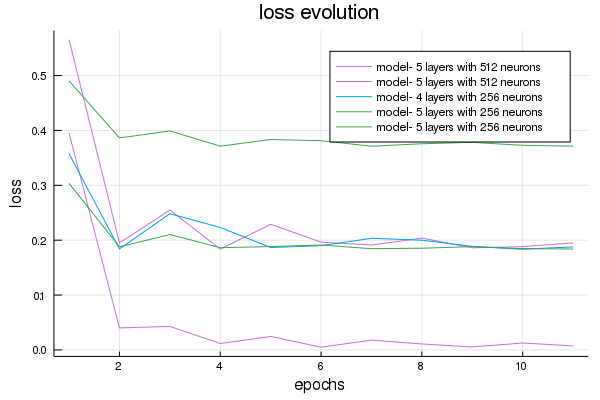

In [93]:
gr(fmt=:png)
plot()
for i = 1:length(model_all_losses)
    this_model_losses = model_all_losses[i]
    this_model = models_tested[i]
    num_layers = length(this_model.layers)
    num_neurons = size(this_model.layers[1].W, 1)
#     p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons")
    colorNum = findColorNum(num_layers, num_neurons)
    p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons", colorNum)
end
display(p)

In [79]:
function findColorNum(num_layers, num_neurons)
    if num_layers ==4 
        if num_neurons == 256
            return 1
        else
            return 2
        end
    elseif num_layers ==5
        if num_neurons == 256
            return 3
        else
            return 4
        end
    end
end

findColorNum (generic function with 1 method)

# True grammar

In [4]:
input_size = 1
output_size = 1
X_train = [zeros(input_size,10) ones(input_size,10) 2*ones(input_size,10) 3*ones(input_size,10) zeros(input_size,10)]
Y_train = [zeros(output_size,10) ones(output_size,10) ones(output_size,10) ones(output_size,10) zeros(output_size,10)]

X_test = [zeros(input_size,2) 2*ones(input_size,2) 3*ones(input_size,2)]
Y_test = [zeros(input_size,2) ones(input_size,2) ones(input_size,2)]


1×6 Array{Float64,2}:
 0.0  0.0  1.0  1.0  1.0  1.0

In [5]:
const grammar = @grammar begin
model = Chain(in_layer, layer, layer, out_layer) | Chain(in_layer, layer, layer, layer, out_layer)
in_layer = Dense(input_size, 256, activation)
out_layer = Dense(256, output_size, activation)
layer = Dense(256,256, activation)
activation = relu
end

1: model = Chain(in_layer, layer, layer, out_layer)
2: model = Chain(in_layer, layer, layer, layer, out_layer)
3: in_layer = Dense(input_size, 256, activation)
4: out_layer = Dense(256, output_size, activation)
5: layer = Dense(256, 256, activation)
6: activation = relu


In [6]:
const S = SymbolTable(grammar)


Dict{Symbol,Any} with 5 entries:
  :output_size => 1
  :relu        => relu
  :Chain       => Chain
  :Dense       => Dense
  :input_size  => 1

In [7]:
# dmap = mindepth_map(grammar)
# best_tree, best_loss = RuleNode(0), Inf

# typ = :model

# tree = rand(RuleNode, grammar, typ, dmap, p.max_depth)
# ex = get_executable(tree, grammar)
# model = Core.eval(S,ex)


UndefVarError: UndefVarError: p not defined

In [17]:
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    model = []
    model = Core.eval(S,ex)
    println(model)
    push!(models_tested, model)
    train_model(model, X_train, Y_train, verbose = false)

    Y_NN = model(X_test)
    println("input $X_test")
    Y_NN = [Tracker.data(ynn) for ynn in Y_NN]
    println("output $Y_NN")
    println("expected output $Y_test")
    los = norm(Y_NN - Y_test)
    push!(model_losses, los)
    println("returning $los")
    return los
end

loss (generic function with 1 method)

In [18]:
using Random
Random.seed!(10)
p = MonteCarlo(2, 2)

models_tested = []
model_losses = []

results_mc = optimize(p, grammar, :model, loss, verbose = true)


samples: 1 of 2
Chain(Dense(1, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 1, NNlib.relu))


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


input [0.0 0.0 2.0 2.0 3.0 3.0]
output Float32[0.0 0.0 1.01624 1.01624 0.992336 0.992336]
expected output [0.0 0.0 1.0 1.0 1.0 1.0]
returning 0.025393422498184843
samples: 2 of 2
Chain(Dense(1, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 1, NNlib.relu))


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


input [0.0 0.0 2.0 2.0 3.0 3.0]
output Float32[0.0 0.0 0.0 0.0 0.0 0.0]
expected output [0.0 0.0 1.0 1.0 1.0 1.0]
returning 2.0


ExprOptResult(2{3{6}5{6}5{6}5{6}4{6}}, 0.025393422498184843, :(Chain(Dense(input_size, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, output_size, relu))), nothing)

In [19]:
(results_mc.expr, results_mc.loss)

(:(Chain(Dense(input_size, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, output_size, relu))), 0.025393422498184843)

In [20]:
@show models_tested
@show model_losses

models_tested = Any[Chain(Dense(1, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 1, relu)), Chain(Dense(1, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 1, relu))]
model_losses = Any[0.0253934, 2.0]


2-element Array{Any,1}:
 0.025393422498184843
 2.0                 

In [21]:
size(X_test)

(1, 6)

In [34]:
ark = 3
println("returning $ark")

returning 3


# Scrap

In [ ]:
# dmap = mindepth_map(grammar)
# best_tree, best_loss = RuleNode(0), Inf

# typ = :model

# tree = rand(RuleNode, grammar, typ, dmap, p.max_depth)
# ex = get_executable(tree, grammar)
#     los = 0.0
# x = 1.0
# S[:x] = x
# model = Core.eval(S,ex)

# X_train = [zeros(input_size,10) ones(input_size,10) 2*ones(input_size,10) 3*ones(input_size,10) zeros(input_size,10)]
# Y_train = [zeros(output_size,10) ones(output_size,10) ones(output_size,10) ones(output_size,10) zeros(output_size,10)]

# train_model(model, X_train, Y_train, verbose = false)

# los = loss(tree, grammar)

In [30]:
@grammar begin
model = Chain(layer, layer, layer, layer, relu) | Chain(layer, layer, layer, layer, layer, relu)
layer = Dense(n, activation)
n = 128|256|512|1024
activation = relu
end

1: model = Chain(layer, layer, layer, layer, relu)
2: model = Chain(layer, layer, layer, layer, layer, relu)
3: layer = Dense(n, activation)
4: n = 128
5: n = 256
6: n = 512
7: n = 1024
8: activation = relu


In [1]:
@grammar begin
model = Chain(layer, layer, relu) | Chain(layer, layer, layer, relu)
layer = Dense(n, activation) | OtherLayerType(...)
n = |(50:50:500)
activation = relu | tanh
end

LoadError: syntax: invalid identifier name "..."

In [ ]:
model2 = Chain(
  Dense(10, 5, σ),
  Dense(5, 2),
  softmax)

In [19]:
imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

UndefVarError: UndefVarError: MNIST not defined

In [ ]:
# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu

m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) |> gpu

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

accuracy(tX, tY)
